In [13]:
import numpy as np
import pandas as pd
import importlib
import random
import simulate_data
from simulation_evaluation import run_test, plot_mse, get_conf_intervals, plot_gain_curves
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from econml.grf import CausalForest

from matplotlib import pyplot as plt

importlib.reload(simulate_data)

<module 'simulate_data' from 'D:\\Delft\\Year 3\\Q4\\code\\research-project\\simulate_data.py'>

In [14]:
data = pd.read_csv("bsc_project_set.csv", index_col=0)

xs = data.copy()

y = xs["mort_28"]
w = xs["peep_regime"]

w = pd.Series(map(lambda x: 0 if x == "low" else 1, w))
y = pd.Series(map(lambda x: 1 if x == False else 0, y))

# xs = xs.drop(columns=["id", "mort_28", "peep", "peep_regime"])
selected_columns = ["age", "weight", "pf_ratio", "po2", "pco2", "driving_pressure", "bilirubin", "platelets", "urea", "fio2", "minute_volume", "plateau_pressure"]
xs = xs[selected_columns]
columns_x = xs.columns

norm_xs = (xs - xs.mean())/xs.std()

imputer = KNNImputer(n_neighbors=2, weights="uniform")
imp_xs = imputer.fit_transform(norm_xs)

imp_xs = pd.DataFrame(data=imp_xs, columns=columns_x)

imp_xs

,age,weight,pf_ratio,po2,pco2,driving_pressure,bilirubin,platelets,urea,fio2,minute_volume,plateau_pressure
0,0.732971,0.183841,-0.026374,-0.049713,-1.422636,-0.364306,1.121030,-1.048713,-0.897592,-0.564826,-0.543738,0.705302
1,-1.005004,1.422974,-0.637005,-0.385550,-0.768253,-1.141620,2.210067,-1.629822,2.693985,0.758913,3.032717,-0.620678
2,1.353676,-0.381057,-0.171336,-0.406111,-0.403630,1.468983,0.409822,-0.668334,0.703662,-0.434729,-0.035368,0.317210
3,1.353676,0.100018,-0.319055,-1.169822,-0.403630,1.395651,-0.190259,0.023680,1.738181,-1.503965,-0.868889,0.640620
4,0.050195,-0.654395,-0.577049,-0.737052,-0.334933,-1.072479,-0.531046,2.898673,-0.720674,-0.385943,-1.051634,-1.236080
...,...,...,...,...,...,...,...,...,...,...,...,...
3936,0.919183,-1.128181,-0.711144,0.068026,-0.395043,1.219655,-0.068020,0.112283,0.478767,0.541000,-0.428608,0.252528
3937,0.732971,0.475402,-0.527518,-0.793421,-0.300585,-0.540301,-0.501413,-1.092709,2.250942,-0.411497,-0.966353,-1.028174
3938,0.236407,0.438957,-0.701828,-0.554080,0.137359,0.281012,0.325366,1.026414,0.532742,1.377339,-0.299739,1.869576
3939,0.298477,0.245798,-0.425805,-0.814696,-0.156321,0.075683,0.009768,-0.423609,-0.522017,0.150708,-0.298318,0.113924


In [15]:
full_data = imp_xs.assign(W=w, Y=y)

In [16]:
lin_reg_0 = LinearRegression()
lin_reg_0.fit(X=full_data.query("W==0")[columns_x].values, y=full_data.query("W==0")["Y"])

lin_reg_1 = LinearRegression()
lin_reg_1.fit(X=full_data.query("W==1")[columns_x].values, y=full_data.query("W==1")["Y"])

# lin_reg_0.predict(full_data[columns_x].values)

LinearRegression()

In [17]:
knn_0 = KNeighborsRegressor(n_neighbors=5)
knn_1 = KNeighborsRegressor(n_neighbors=5)

knn_0.fit(X=full_data.query("W==0")[columns_x].values, y=full_data.query("W==0")["Y"])
knn_1.fit(X=full_data.query("W==1")[columns_x].values, y=full_data.query("W==1")["Y"])

# knn_0.predict(full_data[columns_x].values)

KNeighborsRegressor()

In [18]:
tree_0 = DecisionTreeRegressor(min_samples_leaf=15)
tree_1 = DecisionTreeRegressor(min_samples_leaf=15)

tree_0.fit(X=full_data.query("W==0")[columns_x].values, y=full_data.query("W==0")["Y"])
tree_1.fit(X=full_data.query("W==1")[columns_x].values, y=full_data.query("W==1")["Y"])

# tree_0.predict(full_data[columns_x].values)

DecisionTreeRegressor(min_samples_leaf=15)

In [19]:
d = 12
vars = random.sample(range(d), k=5)
e = lambda x: 0.025 + sum(list(map(lambda v: 0.04 if x[v] * ((-1) ** (v+1)) >= 0 else 0, vars)))
mu_0 = lambda x: np.mean([lin_reg_0.predict(np.reshape(x, (1,-1)))[0], knn_0.predict(np.reshape(x, (1,-1)))[0], tree_0.predict(np.reshape(x, (1,-1)))[0]])
mu_1 = lambda x: np.mean([lin_reg_1.predict(np.reshape(x, (1,-1)))[0], knn_1.predict(np.reshape(x, (1,-1)))[0], tree_1.predict(np.reshape(x, (1,-1)))[0]])
n_train = 40000
n_test = 10000
reps = 50

In [20]:
training_sizes, mse_s_list, mse_t_list, mse_forest_list, mse_knn_list = run_test(d, mu_0, mu_1, e, n_train, n_test, reps)

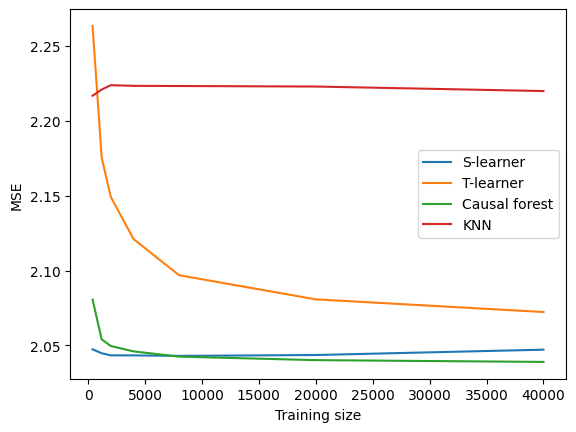

In [21]:
plot_mse(training_sizes, mse_s_list, mse_t_list, mse_forest_list, mse_knn_list)

In [22]:
get_conf_intervals(mse_s_list, mse_t_list, mse_forest_list, mse_knn_list)

,Mean,Std dev
S-Learner,2.047212,0.033064
T-Learner,2.072327,0.033120
Causal Forest,2.039040,0.032791
KNN,2.219719,0.036638


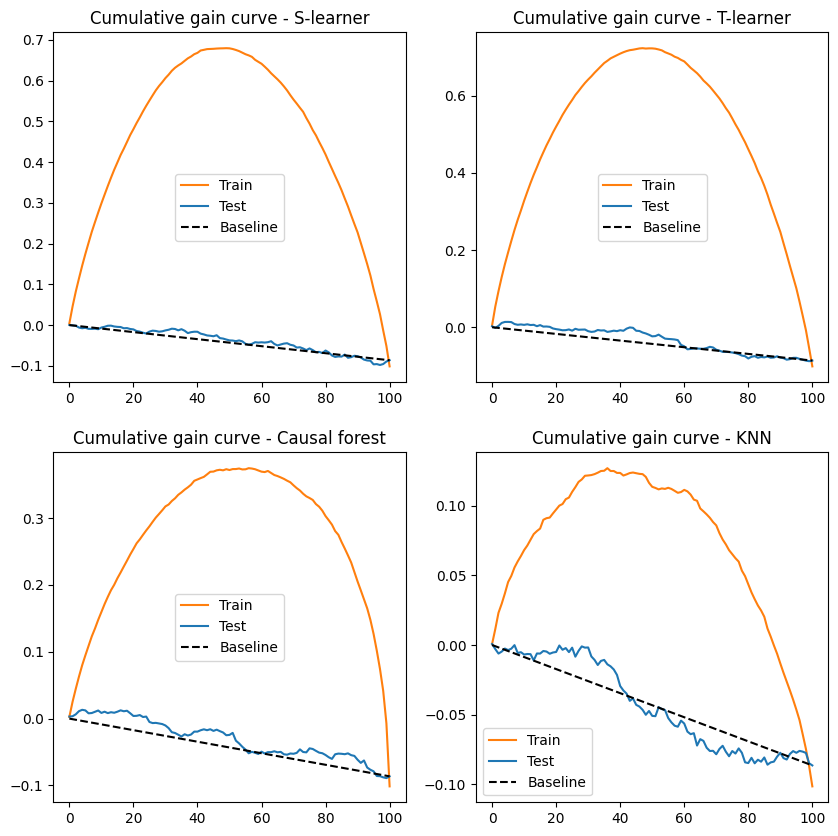

In [23]:
plot_gain_curves(d, mu_0, mu_1, e, n_train, n_test)

In [24]:
train = pd.DataFrame(simulate_data.get_training_set(d, mu_0, mu_1, e, n_train))
test = pd.DataFrame(simulate_data.get_test_set(d, mu_0, mu_1, e, n_test))

train_x = pd.DataFrame(train["X"].tolist(), index=train.index)
train_x.columns = train_x.columns.astype(str)
train_y = train["Y"]
train_w = train["W"]
train_x_s = train_x.assign(W=pd.Series(train_w).values)

test_x = pd.DataFrame(test["X"].tolist(), index=test.index)
test_x.columns = test_x.columns.astype(str)

regr = RandomForestRegressor()
regr.fit(train_x_s, train_y)

out = test.assign(E_1=regr.predict(test_x.assign(**{"W": 1})), E_0=regr.predict(test_x.assign(**{"W": 0})), DIFF=regr.predict(test_x.assign(**{"W": 1})) - regr.predict(test_x.assign(**{"W": 0})))
out

,X,W,Y,Y0,Y1,E_1,E_0,DIFF
0,"[-0.21051093671615567, 0.1330806013300085, 0.1...",1,1.065533,-0.608284,1.065533,0.754575,0.751408,0.003167
1,"[-0.5898175495771149, -0.3956392137007243, 1.4...",0,0.675249,0.675249,1.417063,0.517691,0.605823,-0.088132
2,"[1.5063939034034142, -0.3542406222324839, -0.2...",0,0.673700,0.673700,1.746078,0.182629,0.488629,-0.306000
3,"[-2.062717444244131, 2.1836132860754898, -1.88...",1,1.105132,1.407885,1.105132,0.753851,0.998931,-0.245080
4,"[-0.6519043397545077, -0.19645126570303978, 1....",0,1.400267,1.400267,1.211423,0.712659,0.945927,-0.233268
...,...,...,...,...,...,...,...,...
9995,"[-0.5408854584185814, 0.9928158925708185, 0.23...",0,0.990502,0.990502,0.778356,0.589072,0.695098,-0.106026
9996,"[1.4906258971550792, 1.7429137798877243, -0.13...",0,0.861005,0.861005,-0.572619,0.673941,0.644950,0.028991
9997,"[0.5599595474182312, 0.5931966663589143, -0.81...",0,1.177061,1.177061,-0.923917,0.359961,0.751621,-0.391660
9998,"[-0.6146672281256005, 0.4085587620929249, 0.88...",0,2.797591,2.797591,0.383531,0.684387,0.776287,-0.091899
